In [1]:
import re, time, warnings, os, sys, copy
import gzip, pickle

import numpy as np
import pandas as pd
import gzip, pickle
import scipy, sklearn, mne

import aux, data, rsa
sys.path.append('../spaces/')
import embeddings as emb
import pubplot as pub
import matplotlib.pyplot as plt

pub.styles.set()
C = pub.colours.equidistant('tab20c', k = 20)

## Supplementary Figures 3-4, Supplementary Tables 4-5
This notebook generates supplementary results for top-k encoding analysis.

In [2]:
k = np.arange(1, 20, 2)

with gzip.open(f'./data/results/encoding_topk_b0-m0-c0.pkl.gz', 'rb') as f:
    r, ß, onesamp, contrasts = pickle.load(f)

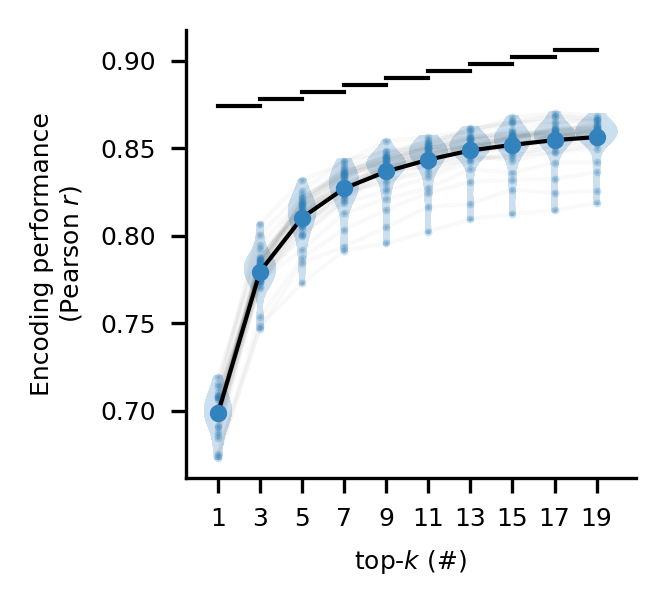

In [25]:
'''
Generate figure 3
'''

enc = r.squeeze().T

fig, ax = pub.figure(nrows = 1, ncols = 1)
pub.dist.violins(enc, colours = [C[0]] * len(k), ax = ax)

ax.set_ylabel('Encoding performance\n' + r'(Pearson $r$)')
ax.set_xlabel(r'top-$k$ (#)')
ax.set_xticks(np.arange(len(k)), labels = k)

absmax = enc.max()
sigs = 1
diff = 0.004

for key in contrasts:
    contrast = contrasts[key]
    
    i, j = key.split('-')
    i, j = int(i), int(j)
    
    p = contrast['p_cor']
    
    if p <= .05:
        ax.plot([i, j], [absmax + sigs * diff, absmax + sigs * diff], color = 'black')
        sigs += 1
    
pub.cosmetics.finish()

fig.savefig(f'./figures/png/suppfig3_topk.png', dpi = 300)
fig.savefig(f'./figures/svg/suppfig3_topk.svg')
fig.savefig(f'./figures/pdf/suppfig3_topk.pdf')

In [33]:
'''
Generate table 4
'''

contrast = []
mu = []
sd = []
t = []
df = []
p = []
d = []

for key in contrasts:
    i, j = key.split('-')
    i, j = int(i), int(j)
    con = contrasts[key]
    
    contrast.append(f'{k[i]}-{k[j]}')
    mu.append(np.round(con['mu'], 3))
    sd.append(np.round(con['sd'], 3))
    t.append(np.round(con['t'], 3))
    df.append(con['df'])
    p.append(con['p_cor'])
    d.append(con['d'])

df = {'contrast': contrast, 'M': mu, 'Std. Dev': sd, 'df': df, 't-value': t, 'p-value': p}
df = pd.DataFrame.from_dict(df)
print(df.to_latex(index = False))

\begin{tabular}{lrrrrr}
\toprule
contrast &     M &  Std. Dev &  df &  t-value &      p-value \\
\midrule
     3-1 & 0.081 &     0.008 &  34 &   61.723 & 1.525150e-35 \\
     5-3 & 0.031 &     0.006 &  34 &   29.964 & 3.981719e-25 \\
     7-5 & 0.017 &     0.004 &  34 &   25.039 & 1.205639e-22 \\
     9-7 & 0.010 &     0.004 &  34 &   15.416 & 3.937666e-16 \\
    11-9 & 0.007 &     0.003 &  34 &   15.337 & 3.828239e-16 \\
   13-11 & 0.005 &     0.003 &  34 &   11.310 & 1.823108e-12 \\
   15-13 & 0.003 &     0.003 &  34 &    6.597 & 4.385328e-07 \\
   17-15 & 0.003 &     0.003 &  34 &    6.134 & 1.156198e-06 \\
   19-17 & 0.002 &     0.002 &  34 &    4.430 & 9.290249e-05 \\
\bottomrule
\end{tabular}



/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_79224/29060152.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index = False))


In [49]:
with gzip.open(f'./data/results/encoding_b0-m0-c0-k19.pkl.gz', 'rb') as f:
    (r_a, ß_a, r_s, ß_s, r_as, ß_as, one_samp, contrasts, cluster_based) = pickle.load(f)

import matplotlib
C1 = pub.colours.equidistant('YlOrRd', k = 20)
cols_inv = [C1[5], C1[12], C1[10]]
cols_spc = [C1[7], C1[13], C1[11]]
cols_bot = [C1[9], C1[14], C1[12]]

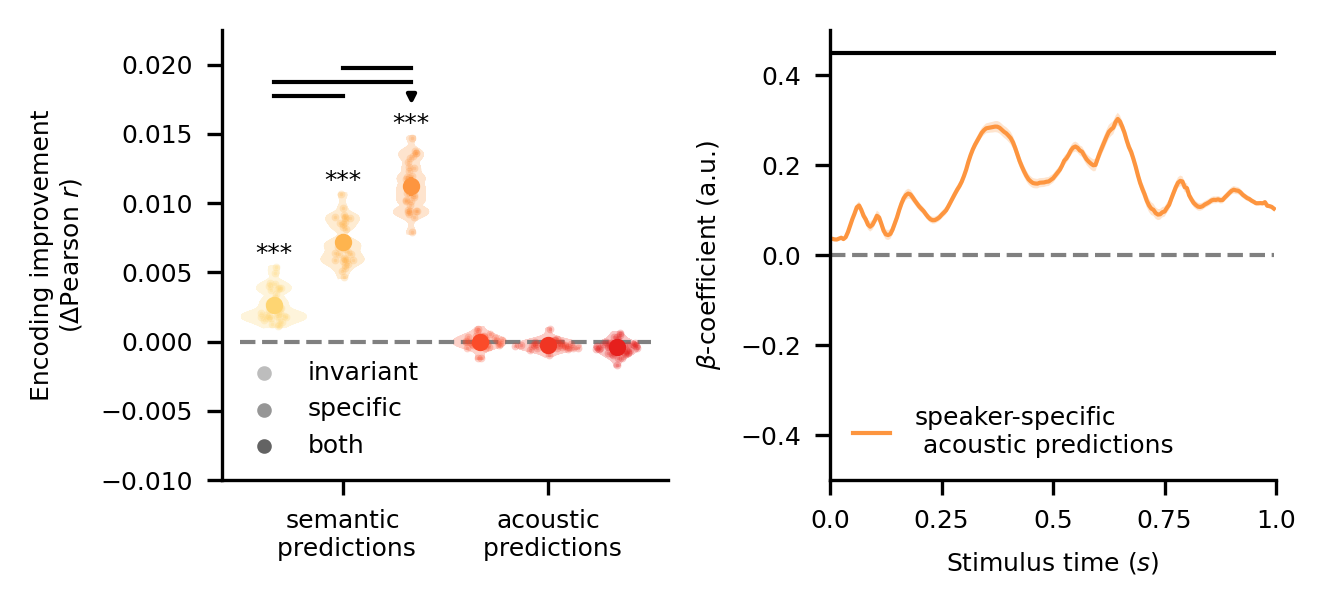

In [110]:
'''
Generate figure 4
'''

fig, ax = pub.figure(nrows = 1, ncols = 2)

d_a = r_a[:,1:] - r_a[:,0,None]
d_s = r_s[:,1:] - r_s[:,0,None]

bw = np.array([d_a, d_s]).flatten()
bw = pub.dist._bandwidth_botev(bw)
vmax = np.abs(np.array([d_a, d_s])).max()

ax[0].plot([-0.5, 5.5], [0, 0], color = 'gray', linestyle = '--')
pub.dist.violins(d_a.T, scatter_dep = False, colours = [cols_inv[0], cols_spc[0], cols_bot[0]], jitter = True, jitter_max = 1.75 * bw, kernel_bandwidth = bw, ax = ax[0])
pub.dist.violins(d_s.T, scatter_dep = False, colours = [cols_inv[1], cols_spc[1], cols_bot[1]], jitter = True, jitter_max = 1.75 * bw, offset_x = 3, kernel_bandwidth = bw, ax = ax[0])

ax[0].scatter([-1], [-1], color = C[18], marker = '.', s = 25, label = 'invariant')
ax[0].scatter([-1], [-1], color = C[17], marker = '.', s = 25, label = 'specific')
ax[0].scatter([-1], [-1], color = C[16], marker = '.', s = 25, label = 'both')

# add significance
sigs = 3
sigs_a = 3
sigs_s = 3
sigs_as = 3
off = 0.001

for k in contrasts:
    # get descriptives
    T, v = k.split(':')
    if T not in ['a', 's', 'as']: v0 = v1 = int(v[1:])
    else: v0, v1 = v[1:].split('-')
    v0, v1 = int(v0), int(v1)
    
    # skip if not required
    if T not in ['a', 's', 's-a']: continue
    
    # get contrast
    contrast = contrasts[k]
    pv = contrast['p_cor']
    
    if pv <= .05:
        lab = pub.significance.__sig_from_p(pv)
        i, j = v0, v1
        
        if T == 'a':
            i, j = v0, v1
                        
            if v1 == 0:
                xy = (i-1, d_a[:,i-1].max() + off)
                ax[0].annotate(lab, xy = xy, xytext = xy, ha = 'center', va = 'center')
                continue
            
            sigs = sigs_a
            sigs_a += 1
        elif T == 's':
            continue
            
            i, j = v0, v1
            
            if v1 == 0:
                xy = (i+2, d_s[:,i-1].max() + off)
                ax[0].annotate(lab, xy = xy, xytext = xy, ha = 'center', va = 'center')
                continue
            
            i, j = i + 3, j + 3
            sigs = sigs_s
            sigs_s += 1
            
        elif T == 's-a':
            continue
            
            i, j = v0, v1 + 3
            
            sigs_as = np.array([sigs_a, sigs_s, sigs_as]).max()
            sigs = sigs_as
            sigs_as += 1
        
        ax[0].plot([i-1, j-1], [vmax + sigs * off, vmax + sigs * off], color = 'black')
        sigs += 1

all_m = np.concatenate((d_a, d_s), axis = 1)
best = all_m.mean(axis = 0).argmax()
ax[0].scatter([best], all_m[:,best].max() + 3 * off, marker = 'v', s = 3, color = 'black')

ax[0].set_ylim([-0.01, 0.0225])
ax[0].set_xlim([-0.75, 5.75])
ax[0].set_xticks([1, 4], labels = ['semantic\n predictions', 'acoustic\n predictions'])
ax[0].set_ylabel('Encoding improvement\n' + r'($\Delta$Pearson $r$)')
pub.cosmetics.legend(ax = ax[0], loc = 'lower left')

ß = ß_a[:,3,4,:]
mu = ß.mean(axis = 0)
se = rsa.stats.bootstrap_se(ß)
t = np.arange(se.shape[0])
cluster = cluster_based['a']['m3']['ß4'][0]

ax[1].plot(t*0, color = 'gray', linestyle = '--')
ax[1].fill_between(t, mu - 1.96 * se, mu + 1.96 * se, edgecolor = None, facecolor = cols_bot[0], alpha = 0.25)
ax[1].plot(mu, color = cols_bot[0], label = 'speaker-specific\n acoustic predictions')

if cluster['p_cor'] <= 0.05:
    tmin, tmax = cluster['tmin'], cluster['tmax']
    ax[1].plot([tmin, tmax], [0.45, 0.45], color = 'black')

ax[1].set_ylim([-0.5, 0.5])
ax[1].set_xlim([0, 200])
ax[1].set_xticks(np.arange(0, 201, 50))
ax[1].set_xticklabels(np.round(np.arange(0, 201, 50)*5e-3, 2))
ax[1].set_ylabel(r'$\beta$-coefficient (a.u.)')
ax[1].set_xlabel(r'Stimulus time ($s$)')
pub.cosmetics.legend(ax = ax[1], loc = 'lower left')

pub.cosmetics.finish()

fig.savefig(f'./figures/png/suppfig4_k19.png', dpi = 300)
fig.savefig(f'./figures/svg/suppfig4_k19.svg')
fig.savefig(f'./figures/pdf/suppfig4_k19.pdf')

In [111]:
contrasts

{'a: 1-0': {'contrast': 'a: 1-0',
  'mu': 0.0026180449269019,
  'sd': 0.0011125273786734243,
  'se': 0.0001868213647986686,
  'lb': 0.0022518750518965096,
  'ub': 0.002984214801907291,
  't': 13.7216344693571,
  'df': 34,
  'p_cor': 3.2266271128695153e-14,
  'p_unc': 2.016641945543447e-15,
  'd': 2.353240897337423},
 'a: 2-0': {'contrast': 'a: 2-0',
  'mu': 0.007165825024260978,
  'sd': 0.001452584760998235,
  'se': 0.0002461257616826794,
  'lb': 0.006683418531362926,
  'ub': 0.007648231517159029,
  't': 28.764986474613846,
  'df': 34,
  'p_cor': 4.738567472632725e-24,
  'p_unc': 1.89542698905309e-25,
  'd': 4.933154482039678},
 'a: 2-1': {'contrast': 'a: 2-1',
  'mu': 0.004547780097359078,
  'sd': 0.0014575505430218655,
  'se': 0.00024600054074655443,
  'lb': 0.0040656190374958314,
  'ub': 0.005029941157222324,
  't': 18.193459638838647,
  'df': 34,
  'p_cor': 8.940283988084645e-18,
  'p_unc': 4.257278089564116e-19,
  'd': 3.1201525869081674},
 'a: 3-0': {'contrast': 'a: 3-0',
  'mu':

In [138]:
'''
Generate table 5
'''

contrast = []
mu = []
sd = []
t = []
df = []
p = []
d = []

for key in contrasts:
    
    x = key.split(':')
    if len(x[0].split('-')) > 1:
        t0, t1 = x[0].split('-')
        p0, p1 = x[1], x[1]
        p0, p1 = p0[1:], p1[1:]
    else:
        t0, t1 = x[0], x[0]
        p0, p1 = x[1].split('-')
        p0 = p0[1:]
    
    if 'as' in [t0, t1]: continue
    if (p0 == '0') & (p1 == '0'): continue
    
    i, j = int(p0), int(p1)
    
    ts = {'a': 'ac.', 's': 'sem.'}
    t0, t1 = ts[t0], ts[t1]
    
    ps = ['baseline', 'inv.', 'spc.', 'bth.']
    p0, p1 = ps[i], ps[j]
    
    name = f'{t0}{p0}-{t1}{p1}' if p1 != 'baseline' else f'{t0}{p0}-baseline'
    con = contrasts[key]
    
    contrast.append(name)
    mu.append(np.round(con['mu'], 4))
    sd.append(np.round(con['sd'], 4))
    t.append(np.round(con['t'], 4))
    df.append(con['df'])
    p.append(con['p_cor'])
    d.append(con['d'])

df = {'contrast': contrast, 'M': mu, 'Std. Dev': sd, 'df': df, 't-value': t, 'p-value': p}
df = pd.DataFrame.from_dict(df)
print(df.to_latex(index = False))

\begin{tabular}{lrrrrr}
\toprule
         contrast &       M &  Std. Dev &  df &  t-value &      p-value \\
\midrule
 ac.inv.-baseline &  0.0026 &    0.0011 &  34 &  13.7216 & 3.226627e-14 \\
 ac.spc.-baseline &  0.0072 &    0.0015 &  34 &  28.7650 & 4.738567e-24 \\
  ac.spc.-ac.inv. &  0.0045 &    0.0015 &  34 &  18.1935 & 8.940284e-18 \\
 ac.bth.-baseline &  0.0112 &    0.0016 &  34 &  40.4066 & 7.298257e-29 \\
  ac.bth.-ac.inv. &  0.0086 &    0.0012 &  34 &  41.4418 & 3.248120e-29 \\
  ac.bth.-ac.spc. &  0.0040 &    0.0012 &  34 &  20.1537 & 4.199722e-19 \\
sem.inv.-baseline & -0.0000 &    0.0004 &  34 &  -0.0919 & 9.273371e-01 \\
sem.spc.-baseline & -0.0002 &    0.0003 &  34 &  -4.7504 & 4.332929e-04 \\
sem.spc.-sem.inv. & -0.0002 &    0.0004 &  34 &  -3.6487 & 8.750919e-03 \\
sem.bth.-baseline & -0.0004 &    0.0005 &  34 &  -5.0595 & 1.869813e-04 \\
sem.bth.-sem.inv. & -0.0004 &    0.0003 &  34 &  -8.9696 & 2.449899e-09 \\
sem.bth.-sem.spc. & -0.0002 &    0.0003 &  34 &  -3.0744 &

/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_79224/842862142.py:49: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index = False))
